<a href="https://colab.research.google.com/github/Doris-QZ/Transformers_from_Scratch--BERT_and_GPT2_in_PyTorch/blob/main/2_Reproducing_BERT_Model_from_Scratch_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook builds the **BERT architecture from scratch in PyTorch** to gain a deeper understanding of how the model works internally. The workflow includes:

* **Data Preparation**: load the processed data from `1. Data For BERT.ipynb` into PyTorch `Dataset`, and wrap it in a `DataLoader`.
* **Model Implementation**: outline the BERT architecture and implement it using the BERT_base configuration.
* **Training**: train the model for **one epoch** on the prepared dataset, and report the **training and test loss** to verify the end-to-end implementation.


In [ ]:
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import copy

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

import transformers
from transformers import get_linear_schedule_with_warmup

In [ ]:
# Use GPU when it's available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Data Preparation

First, we load the data processed in `1. Data For BERT.ipynb`.

In [ ]:
# Load the data
imdb = pd.read_csv('/content/imdb_bert_data.csv', engine='python')

# Take a look at the data
imdb.info()
imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197647 entries, 0 to 197646
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   input_ids       197647 non-null  object
 1   token_type_ids  197647 non-null  object
 2   attention_mask  197647 non-null  object
 3   mlm_labels      197647 non-null  object
 4   nsp_labels      197647 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 7.5+ MB


,input_ids,token_type_ids,attention_mask,mlm_labels,nsp_labels
0,"[101, 103, 4872, 2017, 2008, 2065, 2017, 2123,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1045, 0, 0, 0, 0, 0, 0, 0, 1056, 0, 0, 0, ...",0
1,"[101, 12703, 2024, 25506, 1998, 1996, 5896, 20...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[101, 13109, 103, 6562, 1010, 6854, 2174, 1010...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 6633, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[101, 1026, 7987, 1013, 1028, 1026, 7987, 1013...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1996, 0, 0, 0, 0, ...",0
4,"[101, 7051, 1005, 1000, 1996, 8841, 2158, 1000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1029, 0, 2053, 0, 0, ...",0


In [ ]:
import ast

cols = ['input_ids', 'token_type_ids', 'attention_mask', 'mlm_labels']

# Parse list-like strings in the selected columns into actual Python lists
for col in cols:
    imdb[col] = imdb[col].apply(ast.literal_eval)

type(imdb.iloc[1]['input_ids'])

list

The data is stored in a pandas DataFrame. To use it with the BERT model, we need to load it into a PyTorch `DataLoader`. This involves three steps:

1.   Convert the DataFrame into a PyTorch `Dataset`.
2.   Define a custom collate function.
3.   Wrap the dataset in a `DataLoader`.

In [ ]:
# Define a BERT_Dataset class
class BERT_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Locate the row in the dataframe using the index
        row = self.data.iloc[idx]

        # Extract values from the row and convert them to torch tensors
        input_ids = torch.tensor(row['input_ids'], dtype=torch.long)
        token_type_ids = torch.tensor(row['token_type_ids'], dtype=torch.long)
        attention_mask = torch.tensor(row['attention_mask'], dtype=torch.long)
        mlm_labels = torch.tensor(row['mlm_labels'], dtype=torch.long)
        nsp_labels = torch.tensor(row['nsp_labels'], dtype=torch.long)

        return input_ids, token_type_ids, attention_mask, mlm_labels, nsp_labels

In [ ]:
# Split the data into training and test set
imdb_train_df, imdb_test_df = train_test_split(imdb, test_size=0.2, shuffle=False)

# Create BERT_Dataset instances for training and test sets
imdb_train = BERT_Dataset(imdb_train_df)
imdb_test = BERT_Dataset(imdb_test_df)

imdb_train[0]

(tensor([  101,   103,  4872,  2017,  2008,  2065,  2017,  2123,  1005,   103,
          3046,  2000,  2202,  2023,  2143,  2200,  5667,   103,  3432,   103,
          2009,   103,   103,  4024,  3643,  1010,  2017,  2097,  5247,  2531,
          2781,  1999,  1037,   103, 22249,   103,  1012,   102,  2076,  2023,
          2051,  1010,  1996, 11017,  1998,  9530, 13238,  2699,  2000, 20014,
           103, 13701,  1996,  5292, 21112,   103,  4615,  1998,   103,  2008,
          2016,  3696,  4981,  2437,  9530, 13238,  2014,  2797,  3187,  1998,
         10211,  1012,   102,     0,     0,     0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Define a custom collate function
def collate_fn(batch):
    input_ids_b, token_type_ids_b, attention_mask_b, mlm_labels_b, nsp_labels_b = [], [], [], [], []

    # Append each input to the respective batch list, truncate sequence longer than 512
    for input_ids, token_type_ids, attention_mask, mlm_labels, nsp_labels in batch:
        if len(input_ids) > 512:
            input_ids = input_ids[:512]
            token_type_ids = token_type_ids[:512]
            attention_mask = attention_mask[:512]
            mlm_labels = mlm_labels[:512]

        input_ids_b.append(input_ids)
        token_type_ids_b.append(token_type_ids)
        attention_mask_b.append(attention_mask)
        mlm_labels_b.append(mlm_labels)
        nsp_labels_b.append(nsp_labels)

    # Pad the sequence in the batch with '[PAD]' index (0)
    input_ids_b = pad_sequence(input_ids_b, padding_value=0, batch_first=True)
    token_type_ids_b = pad_sequence(token_type_ids_b, padding_value=0, batch_first=True)
    attention_mask_b = pad_sequence(attention_mask_b, padding_value=0, batch_first=True)
    mlm_labels_b = pad_sequence(mlm_labels_b, padding_value=0, batch_first=True)
    nsp_labels_b = torch.tensor(nsp_labels_b, dtype=torch.long)

    return input_ids_b, token_type_ids_b, attention_mask_b, mlm_labels_b, nsp_labels_b

**The original BERT paper uses a batch size of 256 in pre-training, but we use 4 here to prevent running out of GPU memory.**

In [ ]:
# Wrap the datasets in dataloaders
BATCH_SIZE = 4

train_dataloader = DataLoader(imdb_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(imdb_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 39530
Number of test batches: 9883


### Model Implementation.

**Model Architecture**  

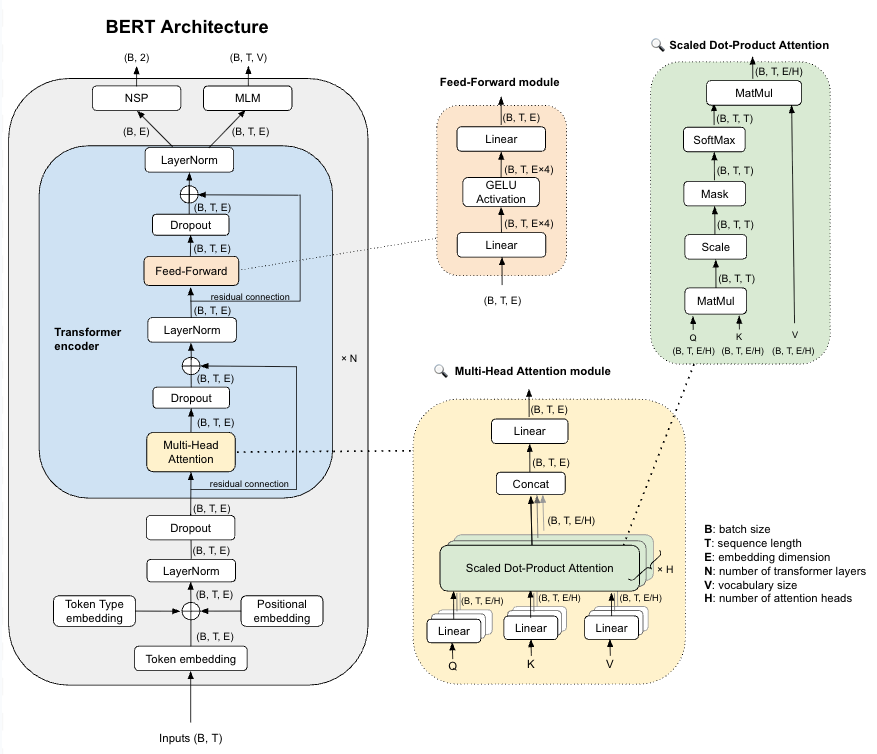

The BERT Model consists of three key components:

1. **Embedding Layer**:  
* Token embedding + Positional embedding + Token Type tmbedding.

2. **Transformer Block**:  
* Each block contains:
    * Multi-head attention
    * Feed-forward module
    * Residual connections and layer normalization applied after each sub-layer
* Repeated **N** times depending on model size: 12 for *BERT-base*, and 24 for *BERT-large*.

3. **Output Layer**:  
* Masked Language Modeling (MLM) head.   
* Next Sentence Prediction (NSP) head


##### **Model Parameters**

We set the parameters of all modules to match the **BERT-base** model described in the original BERT paper:

* Vocabulary size: 30522

* Maximum sequence length: 512

* Hidden size (embedding dimension): 768

* Number of self-attention heads: 12

* Number of layers (Transformer blocks): 12

* Dropout rate: 0.1

* Feed-forward dimension: 3072

* Activation function: GELU

* Optimizer: Adam

* Max learning rate: 1e-4


In [ ]:
# Multi_Head_Attention module for BERT (encoder-style Transformer Block)
class Multi_Head_Attention(nn.Module):
    # Set the parameters to align with the BERT base model
    def __init__(self, num_heads=12, d_model=768, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads     # head size of each scaled dot-product attention

        # Linear projection for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Linear projection for the concatenated scaled_dot_product_attention
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, attention_mask):
        # Q, K, V: [batch_size, num_heads, seq_length, d_k]
        # attention_mask: [batch_size, seq_length]

        # Calculate attention score
        attn_score = Q @ torch.transpose(K, -2, -1) / math.sqrt(self.d_k)   # [B, H, T, T]

        # Expand and reshape the attention mask: [B, T] -> [B, 1, 1, T]
        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Convert attention mask: 1 -> 0 (keep), 0 -> large negative value (mask out)
        extended_mask = (1.0 - attention_mask) * -1e9

        # Add attention mask to the attention scores
        attn_score = attn_score + extended_mask

        # Apply softmax to get attention weight
        attn_weight = attn_score.softmax(dim=-1)   # [B, H, T, T]

        # Attention output
        attn_output = attn_weight @ V       # [B, H, T, d_k]

        return attn_output

    def forward(self, x, attention_mask):
        # x: [batch_size, seq_length, d_model]
        # attention_mask: [batch_size, seq_length]

        batch_size = x.shape[0]

        # Linear projection and reshape -> [B, H, T, d_k]
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Get scaled dot-product attention output
        attn_output = self.scaled_dot_product_attention(Q, K, V, attention_mask)    # [B, H, T, d_k]

        # Concat attention heads
        concat_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model) # [B, T, E]

        # Linear projection
        output = self.W_o(concat_output)   # [B, T, E]

        return output


In [ ]:
# Feed_Forward module for BERT (encoder-style Transformer Block)
class Feed_Forward(nn.Module):
    def __init__(self, d_model=768, d_ff=3072, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.gelu = nn.GELU()

    def forward(self, x):
        # x shape: [batch_size, seq_length, d_model]

        output = self.gelu(self.linear1(x))   # [B, T, d_ff]
        output = self.linear2(output)    # [B, T, E]

        return output

In [ ]:
# Transformer Encoder for BERT
class Transformer_Encoder(nn.Module):
    def __init__(self, num_heads=12, d_model=768, d_ff=3072, dropout=0.1):
        super().__init__()

        # Multi-Head Attention module
        self.multi_head_Attn = Multi_Head_Attention(num_heads, d_model, dropout)

        # Feed-Forward module
        self.feed_forward = Feed_Forward(d_model, d_ff, dropout)

        # Dropout and LayerNorm applied after Multi-head attention
        self.dropout_1 = nn.Dropout(p=dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)

        # Dropout and LayerNorm applied after feed-forward module
        self.dropout_2 = nn.Dropout(p=dropout)
        self.layer_norm2 = nn.LayerNorm(d_model)


    def forward(self, x, attention_mask):
        # Multi-Head Attention
        output = self.multi_head_Attn(x, attention_mask)

        # Dropout
        output = self.dropout_1(output)

        # Add & Norm
        resid_output1 = self.layer_norm1(output + x)

        # Feed-Forward
        output = self.feed_forward(resid_output1)

        # Dropout
        output = self.dropout_2(output)

        # Add & Norm
        resid_output2 = self.layer_norm2 (output + resid_output1)

        return resid_output2

In [ ]:
class BERT_Model(nn.Module):
    def __init__(self, vocab_size=30522, num_layers=12, num_heads=12, d_model=768, d_ff=3072, max_seq_len=512, dropout=0.1):
        super().__init__()

        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_embedding = nn.Embedding(max_seq_len, d_model)
        self.token_type_embedding = nn.Embedding(2, d_model)

        # LayerNorm and dropout applied on embeddings
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=dropout)

        # Transformer encoder
        transformer_encoder = Transformer_Encoder(num_heads, d_model, d_ff, dropout)
        self.transformer_block = nn.ModuleList([copy.deepcopy(transformer_encoder) for _ in range(num_layers)])


        # Output layer
        self.mlm_linear = nn.Linear(d_model, vocab_size)
        self.nsp_linear = nn.Linear(d_model, 2)

    def forward(self, input_ids, token_type_ids, attention_mask):
        # input shape: [batch_size, seq_length]

        # Embedding Layer
        token_embedding = self.token_embedding(input_ids)
        pos = torch.arange(0, input_ids.shape[1], dtype=torch.long, device=input_ids.device)
        positional_embedding = self.positional_embedding(pos)
        token_type_embedding = self.token_type_embedding(token_type_ids)
        bert_embedding = token_embedding + positional_embedding + token_type_embedding  # [B, T, E]

        output = self.dropout(self.layer_norm(bert_embedding))  # [B, T, E]

        # Transformer Blocks
        for encoder in self.transformer_block:
            output = encoder(output, attention_mask)     # [B, T, E]

        # MLM head: predict masked tokens
        mlm_output = self.mlm_linear(output)        # [B, T, V]

        # NSP head: predict next sentence using [CLS] embedding
        nsp_output = self.nsp_linear(output[:, 0, :])  # [B, 2]

        return mlm_output, nsp_output

### Training

We train the model for **one epoch** on the prepared dataset, and report the **training and test loss** to verify that the implementation works end-to-end.

In [ ]:
# Instantiate a BERT model
model = BERT_Model(vocab_size=30522,
                   num_layers=12,
                   num_heads=12,
                   d_model=768,
                   d_ff=3072,
                   max_seq_len=512,
                   dropout=0.1).to(device)

# Define the optimizer
optimizer = Adam(params=model.parameters(),
                 lr=1e-4,
                 weight_decay=0.01)

# Define the learning rate schedule
EPOCHS = 1
training_steps = EPOCHS * len(train_dataloader)
warmup_steps = int(training_steps * 0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=training_steps)

# Define the loss function
mlm_loss = nn.CrossEntropyLoss(ignore_index=0)    # ignore '[PAD]' index
nsp_loss = nn.CrossEntropyLoss()

In [ ]:
# Define the training loop
def training_loop(model, train_dataloader, test_dataloader, optimizer, lr_scheduler, mlm_loss_fn, nsp_loss_fn, epochs):
    history = {'train_loss': [],
               'test_loss': []}

    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        train_loss = 0

        # Iterate through the train_dataloader
        for i, data in enumerate(train_dataloader):
            input_ids = data[0].to(device)
            token_type_ids = data[1].to(device)
            attention_mask = data[2].to(device)
            mlm_labels = data[3].to(device)
            nsp_labels = data[4].to(device)

            # Reset the gradients of the model's parameters to zero
            optimizer.zero_grad()

            # Forward pass
            mlm_output, nsp_output = model(input_ids, token_type_ids, attention_mask)

            # Calculate the train loss
            mlm_loss = mlm_loss_fn(mlm_output.view(-1, mlm_output.shape[-1]), mlm_labels.view(-1))
            nsp_loss = nsp_loss_fn(nsp_output, nsp_labels)
            loss = mlm_loss + nsp_loss
            train_loss += loss.item()

            # Back propagation(computes the gradients)
            loss.backward()

            # Clip the gradient norm of the parameters to prevent the exploding gradient problem
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Updates the model's parameters based on the gradients
            optimizer.step()

            # Updates the learning rate of the optimizer based on the predefined schedule
            lr_scheduler.step()

        train_loss /= len(train_dataloader)
        history['train_loss'].append(train_loss)

        # Set model to evaluation mode
        model.eval()
        test_loss = 0

        # Iterate through the test_dataloader
        for i, data in enumerate(test_dataloader):
            input_ids = data[0].to(device)
            token_type_ids = data[1].to(device)
            attention_mask = data[2].to(device)
            mlm_labels = data[3].to(device)
            nsp_labels = data[4].to(device)

            # Forward pass
            mlm_output, nsp_output = model(input_ids, token_type_ids, attention_mask)

            # Calculate the test loss
            mlm_loss = mlm_loss_fn(mlm_output.view(-1, mlm_output.shape[-1]), mlm_labels.view(-1))
            nsp_loss = nsp_loss_fn(nsp_output, nsp_labels)
            loss = mlm_loss + nsp_loss
            test_loss += loss.item()

        test_loss /= len(test_dataloader)
        history['test_loss'].append(test_loss)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    return history

In [ ]:
# Train the model for one epoch and print out the training and test loss
history = training_loop(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        lr_scheduler=lr_scheduler,
                        mlm_loss_fn=mlm_loss,
                        nsp_loss_fn=nsp_loss,
                        epochs=EPOCHS)


Epoch 0 | Train Loss: 7.8472 | Test Loss: 7.7364


In [ ]:
history

{'train_loss': [7.8472014594856105], 'test_loss': [7.736381924756683]}

### Reference

* Devlin, Jacob, et al. "[Bert: Pre-training of deep bidirectional transformers for language understanding.](https://arxiv.org/abs/1810.04805)" Proceedings of the 2019 conference of the North American chapter of the association for computational linguistics: human language technologies, volume 1 (long and short papers). 2019.
* Vaswani, Ashish, et al. "[Attention is all you need.](https://arxiv.org/abs/1706.03762)" Advances in neural information processing systems 30 (2017).
* Adrian Tam. [Linear Layers and Activation Functions in Transformer Models.](https://machinelearningmastery.com/linear-layers-and-activation-functions-in-transformer-models/) 2025